# Import Libraries & Set Up
---

In [1]:
import warnings
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')

palette = ['#800080', '#8A2BE2', '#FF69B4', '#DA70D6', '#9370DB', '#DDA0DD', '#BA55D3']
gradient_palette = sns.light_palette('#620080', as_cmap=True)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
sns.set_theme(style="whitegrid", palette=palette)

# Dementia Dataset
---

## Import Dataset & Examine
---

### Import Dataset
---

In [3]:
dementia_df = pd.read_csv('data/dementia_data-MRI-features.csv')

### Dataset Info & Structure
---

In [4]:
print(dementia_df.shape)

(373, 15)


In [5]:
print(dementia_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB
None


In [6]:
dementia_df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


### Statistical Summary
---

In [7]:
dementia_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Visit,373.0,1.882038,0.922843,1.000,1.000,2.000,2.000,5.000
MR Delay,373.0,595.104558,635.485118,0.000,0.000,552.000,873.000,2639.000
Age,373.0,77.013405,7.640957,60.000,71.000,77.000,82.000,98.000
EDUC,373.0,14.597855,2.876339,6.000,12.000,15.000,16.000,23.000
SES,354.0,2.460452,1.134005,1.000,2.000,2.000,3.000,5.000
MMSE,371.0,27.342318,3.683244,4.000,27.000,29.000,30.000,30.000
CDR,373.0,0.290885,0.374557,0.000,0.000,0.000,0.500,2.000
eTIV,373.0,1488.128686,176.139286,1106.000,1357.000,1470.000,1597.000,2004.000
nWBV,373.0,0.729568,0.037135,0.644,0.700,0.729,0.756,0.837
ASF,373.0,1.195461,0.138092,0.876,1.099,1.194,1.293,1.587


In [8]:
print(f"Number of unique subjects: {len(dementia_df['Subject ID'].unique())}")

Number of unique subjects: 150


## Preparing the Data
---

### Target Examination
---

<Axes: xlabel='Group', ylabel='count'>

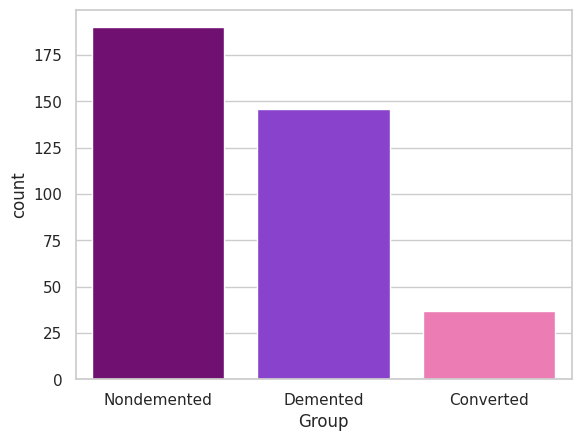

In [9]:
sns.countplot(x=dementia_df['Group'], palette=palette)

In [10]:
dementia_df.Group.value_counts()

Group
Nondemented    190
Demented       146
Converted       37
Name: count, dtype: int64

The converted category consists of 37 records for 14 subjects.

In [11]:
dementia_df.loc[dementia_df.Group == 'Converted']

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
33,OAS2_0018,OAS2_0018_MR1,Converted,1,0,F,R,87,14,1.0,30.0,0.0,1406,0.715,1.248
34,OAS2_0018,OAS2_0018_MR3,Converted,3,489,F,R,88,14,1.0,29.0,0.0,1398,0.713,1.255
35,OAS2_0018,OAS2_0018_MR4,Converted,4,1933,F,R,92,14,1.0,27.0,0.5,1423,0.696,1.234
36,OAS2_0020,OAS2_0020_MR1,Converted,1,0,M,R,80,20,1.0,29.0,0.0,1587,0.693,1.106
37,OAS2_0020,OAS2_0020_MR2,Converted,2,756,M,R,82,20,1.0,28.0,0.5,1606,0.677,1.093
38,OAS2_0020,OAS2_0020_MR3,Converted,3,1563,M,R,84,20,1.0,26.0,0.5,1597,0.666,1.099
57,OAS2_0031,OAS2_0031_MR1,Converted,1,0,F,R,86,12,3.0,30.0,0.0,1430,0.718,1.227
58,OAS2_0031,OAS2_0031_MR2,Converted,2,446,F,R,88,12,3.0,30.0,0.0,1445,0.719,1.215
59,OAS2_0031,OAS2_0031_MR3,Converted,3,1588,F,R,91,12,3.0,28.0,0.5,1463,0.696,1.199
81,OAS2_0041,OAS2_0041_MR1,Converted,1,0,F,R,71,16,1.0,27.0,0.0,1289,0.771,1.362


All those classified as Converted were Nondemented on their first visit and Demented on the final visit according to the data card.

We can hence resolve this category into Nondemented (first visit) and Demented (last visit), dropping nine records which lie between the first and final visits.

In [12]:
nondemented = [33,36,57,81,114,194,218,245,261,271,273,295,297,346]
demented = [35,38,59,83,115,195,220,246,265,272,274,296,298,348]
drop = [34,37,58,82,219,262,263,264,347]

In [13]:
for n in nondemented:
    dementia_df.Group.iloc[n] = 'Nondemented'
for n in demented:
    dementia_df.Group.iloc[n] = 'Demented'

In [14]:
dementia_df = dementia_df.drop(index =[34,37,58,82,219,262,263,264,347])

Now we can drop the unneeded columns.

In [15]:
dementia_df = dementia_df.drop(columns = ['Subject ID','MRI ID'])

Now we can visualise the target following these changes.

<Axes: xlabel='Group', ylabel='count'>

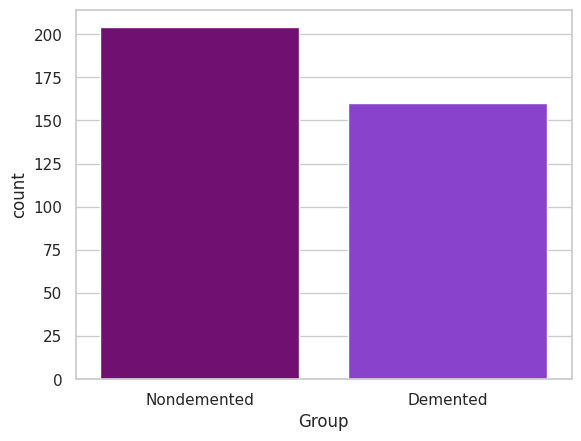

In [16]:
sns.countplot(x=dementia_df['Group'], palette=palette)

In [17]:
dementia_df.Group.value_counts()

Group
Nondemented    204
Demented       160
Name: count, dtype: int64

### Data Types
---

We will change all categorical features to be numerical to make it easier to work with for now.

In [18]:
dementia_df['Group'] = dementia_df['Group'].map({'Nondemented': 0, 'Demented': 1})
dementia_df['M/F'] = dementia_df['M/F'].map({'M': 0, 'F': 1})
dementia_df['Hand'] = dementia_df['Hand'].map({'R': 0, 'L': 1})

In [19]:
dementia_df['Group'] = dementia_df['Group'].astype(int)
dementia_df['M/F'] = dementia_df['M/F'].astype(int)
dementia_df['Hand'] = dementia_df['Hand'].astype(int)

### Missing Values
---

In [20]:
dementia_df.isnull().sum()

Group        0
Visit        0
MR Delay     0
M/F          0
Hand         0
Age          0
EDUC         0
SES         19
MMSE         2
CDR          0
eTIV         0
nWBV         0
ASF          0
dtype: int64

Visualise the missing data to see if there is a pattern.

In [21]:
dementia_df[dementia_df.isnull().any(axis=1)]

,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
2,1,1,0,0,0,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,1,2,560,0,0,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,1,3,1895,0,0,80,12,NaN,22.0,0.5,1698,0.701,1.034
10,1,1,0,0,0,71,16,NaN,28.0,0.5,1357,0.748,1.293
11,1,3,518,0,0,73,16,NaN,27.0,1.0,1365,0.727,1.286
12,1,4,1281,0,0,75,16,NaN,27.0,1.0,1372,0.710,1.279
134,1,1,0,1,0,80,12,NaN,30.0,0.5,1430,0.737,1.228
135,1,2,490,1,0,81,12,NaN,27.0,0.5,1453,0.721,1.208
207,1,1,0,1,0,80,12,NaN,27.0,0.5,1475,0.762,1.190
208,1,2,807,1,0,83,12,NaN,23.0,0.5,1484,0.750,1.183


We have already dropped nine rows, so another 19 would be too many to drop.

All rows with missing values are from demented patients, so we cannot use basic imputation as it would introduce bias.

Imputation by group could be used, but this may over-simplify the data and dilute context-specific patterns.

Therefore, K-Nearest-Neighbours imputation will be used.

In [22]:
from sklearn.impute import KNNImputer

In [23]:
imputer = KNNImputer(n_neighbors=5)

In [24]:
dementia_df = pd.DataFrame(imputer.fit_transform(dementia_df), columns=dementia_df.columns)

Check that there are no more missing values.

In [25]:
dementia_df.isnull().sum()

Group       0
Visit       0
MR Delay    0
M/F         0
Hand        0
Age         0
EDUC        0
SES         0
MMSE        0
CDR         0
eTIV        0
nWBV        0
ASF         0
dtype: int64

## Data Distribution & Correlations
---

### Skewness Analysis
---

In [26]:
dementia_df.skew()

Group       0.244553
Visit       1.066421
MR Delay    0.963429
M/F        -0.301266
Hand        0.000000
Age         0.167696
EDUC       -0.009803
SES         0.189790
MMSE       -2.328402
CDR         1.324719
eTIV        0.504298
nWBV        0.215351
ASF         0.078047
dtype: float64

We can see that variables like Hand, EDUC, and ASF are nearly symmetrically distributed, while others show slight to moderate skewness.

MMSE is highly negatively skewed, and CDR is highly positively skewed.

We can compare this to the skewness of features for demented and non-demented patients specifically.

In [27]:
demented = dementia_df[dementia_df['Group'] == 1]
non_demented = dementia_df[dementia_df['Group'] == 0]

In [28]:
skew_comparison = pd.DataFrame({
    'Overall': dementia_df.skew(),
    'Non-Demented': non_demented.skew(),
    'Demented': demented.skew()
})

In [29]:
print(skew_comparison)

           Overall  Non-Demented  Demented
Group     0.244553      0.000000  0.000000
Visit     1.066421      1.028822  1.088717
MR Delay  0.963429      0.807749  1.195434
M/F      -0.301266     -0.784295  0.254367
Hand      0.000000      0.000000  0.000000
Age       0.167696      0.071220  0.320131
EDUC     -0.009803      0.126381 -0.061429
SES       0.189790      0.342371 -0.023876
MMSE     -2.328402     -1.084445 -1.478195
CDR       1.324719      8.123034  2.149844
eTIV      0.504298      0.489330  0.520014
nWBV      0.215351      0.021469  0.331701
ASF       0.078047      0.060733  0.111530


We can plot this data to more easily visualise it.

To do this we need to ensure the skew_comparison DataFrame has a column for variable names.

In [30]:
skew_comparison = skew_comparison.reset_index().rename(columns={'index': 'Variable'})

And then reshape the DataFrame.

In [31]:
skew_comparison = pd.melt(skew_comparison, id_vars='Variable', var_name='Group', value_name='Skewness')

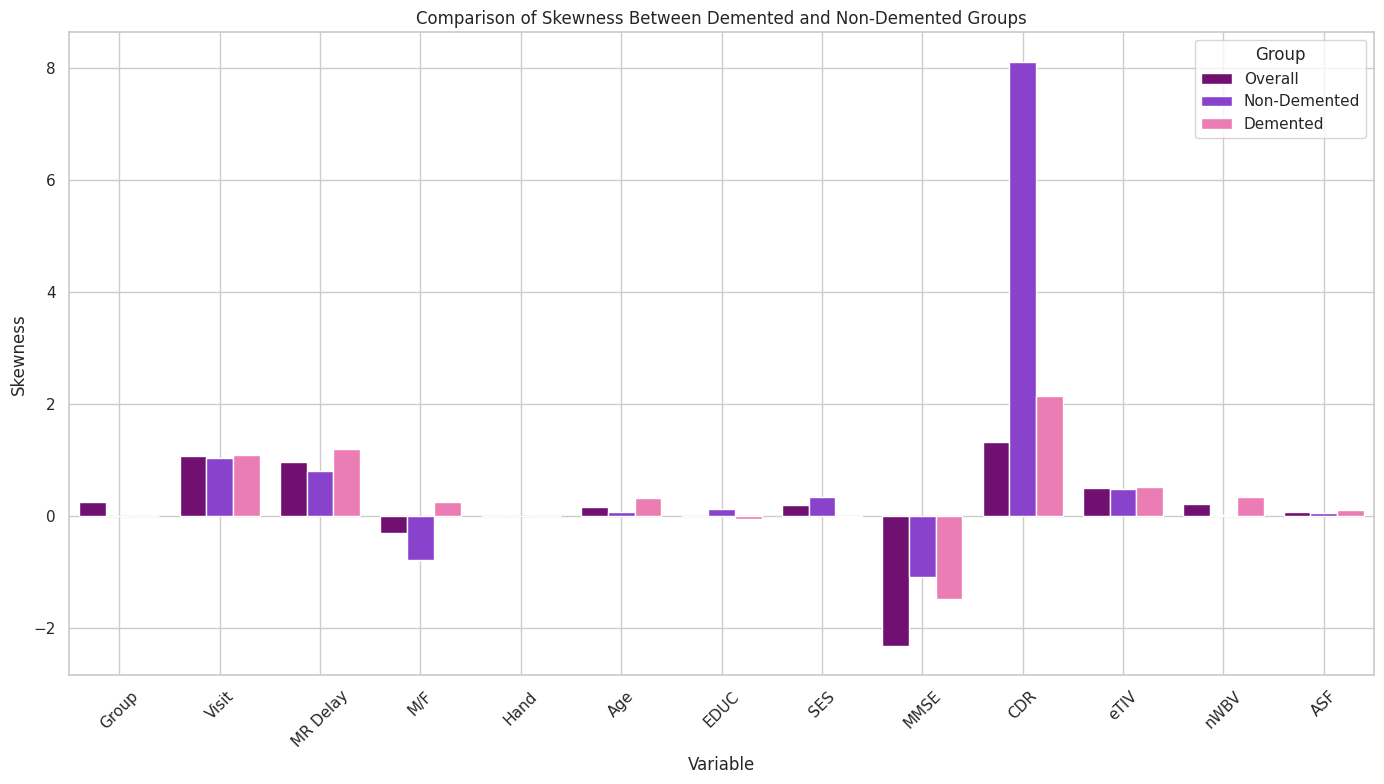

In [32]:
plt.figure(figsize=(14, 8))
sns.barplot(x='Variable', y='Skewness', hue='Group', data=skew_comparison)
plt.title('Comparison of Skewness Between Demented and Non-Demented Groups')
plt.xlabel('Variable')
plt.ylabel('Skewness')
plt.xticks(rotation=45)
plt.legend(title='Group')
plt.grid(True)
plt.tight_layout()
plt.show()

The skewness analysis reveals key differences between the Non-Demented and Demented groups. MMSE and CDR show significant skew, with MMSE negatively skewed (indicating lower cognitive scores for the demented group) and CDR positively skewed (suggesting more advanced stages of dementia in demented individuals).

Age is more skewed in the Demented group, indicating that individuals in this group are, on average, older. MR Delay is right-skewed in the Demented group, pointing to longer delays for this group. The M/F distribution is left-skewed in the Non-Demented group, showing a higher proportion of females, while the Demented group has a more balanced gender distribution.

SES shows a higher skew in the Non-Demented group, suggesting that this group generally has a higher socioeconomic status. Finally, the CDR variable has a significant positive skew in the Non-Demented group, with most individuals scoring 0, indicating no dementia. These patterns highlight significant differences in cognitive function, demographics, and clinical measures between the two groups.

### Histogram
---

array([[<Axes: title={'center': 'Group'}>,
        <Axes: title={'center': 'Visit'}>,
        <Axes: title={'center': 'MR Delay'}>,
        <Axes: title={'center': 'M/F'}>],
       [<Axes: title={'center': 'Hand'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'EDUC'}>,
        <Axes: title={'center': 'SES'}>],
       [<Axes: title={'center': 'MMSE'}>,
        <Axes: title={'center': 'CDR'}>,
        <Axes: title={'center': 'eTIV'}>,
        <Axes: title={'center': 'nWBV'}>],
       [<Axes: title={'center': 'ASF'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

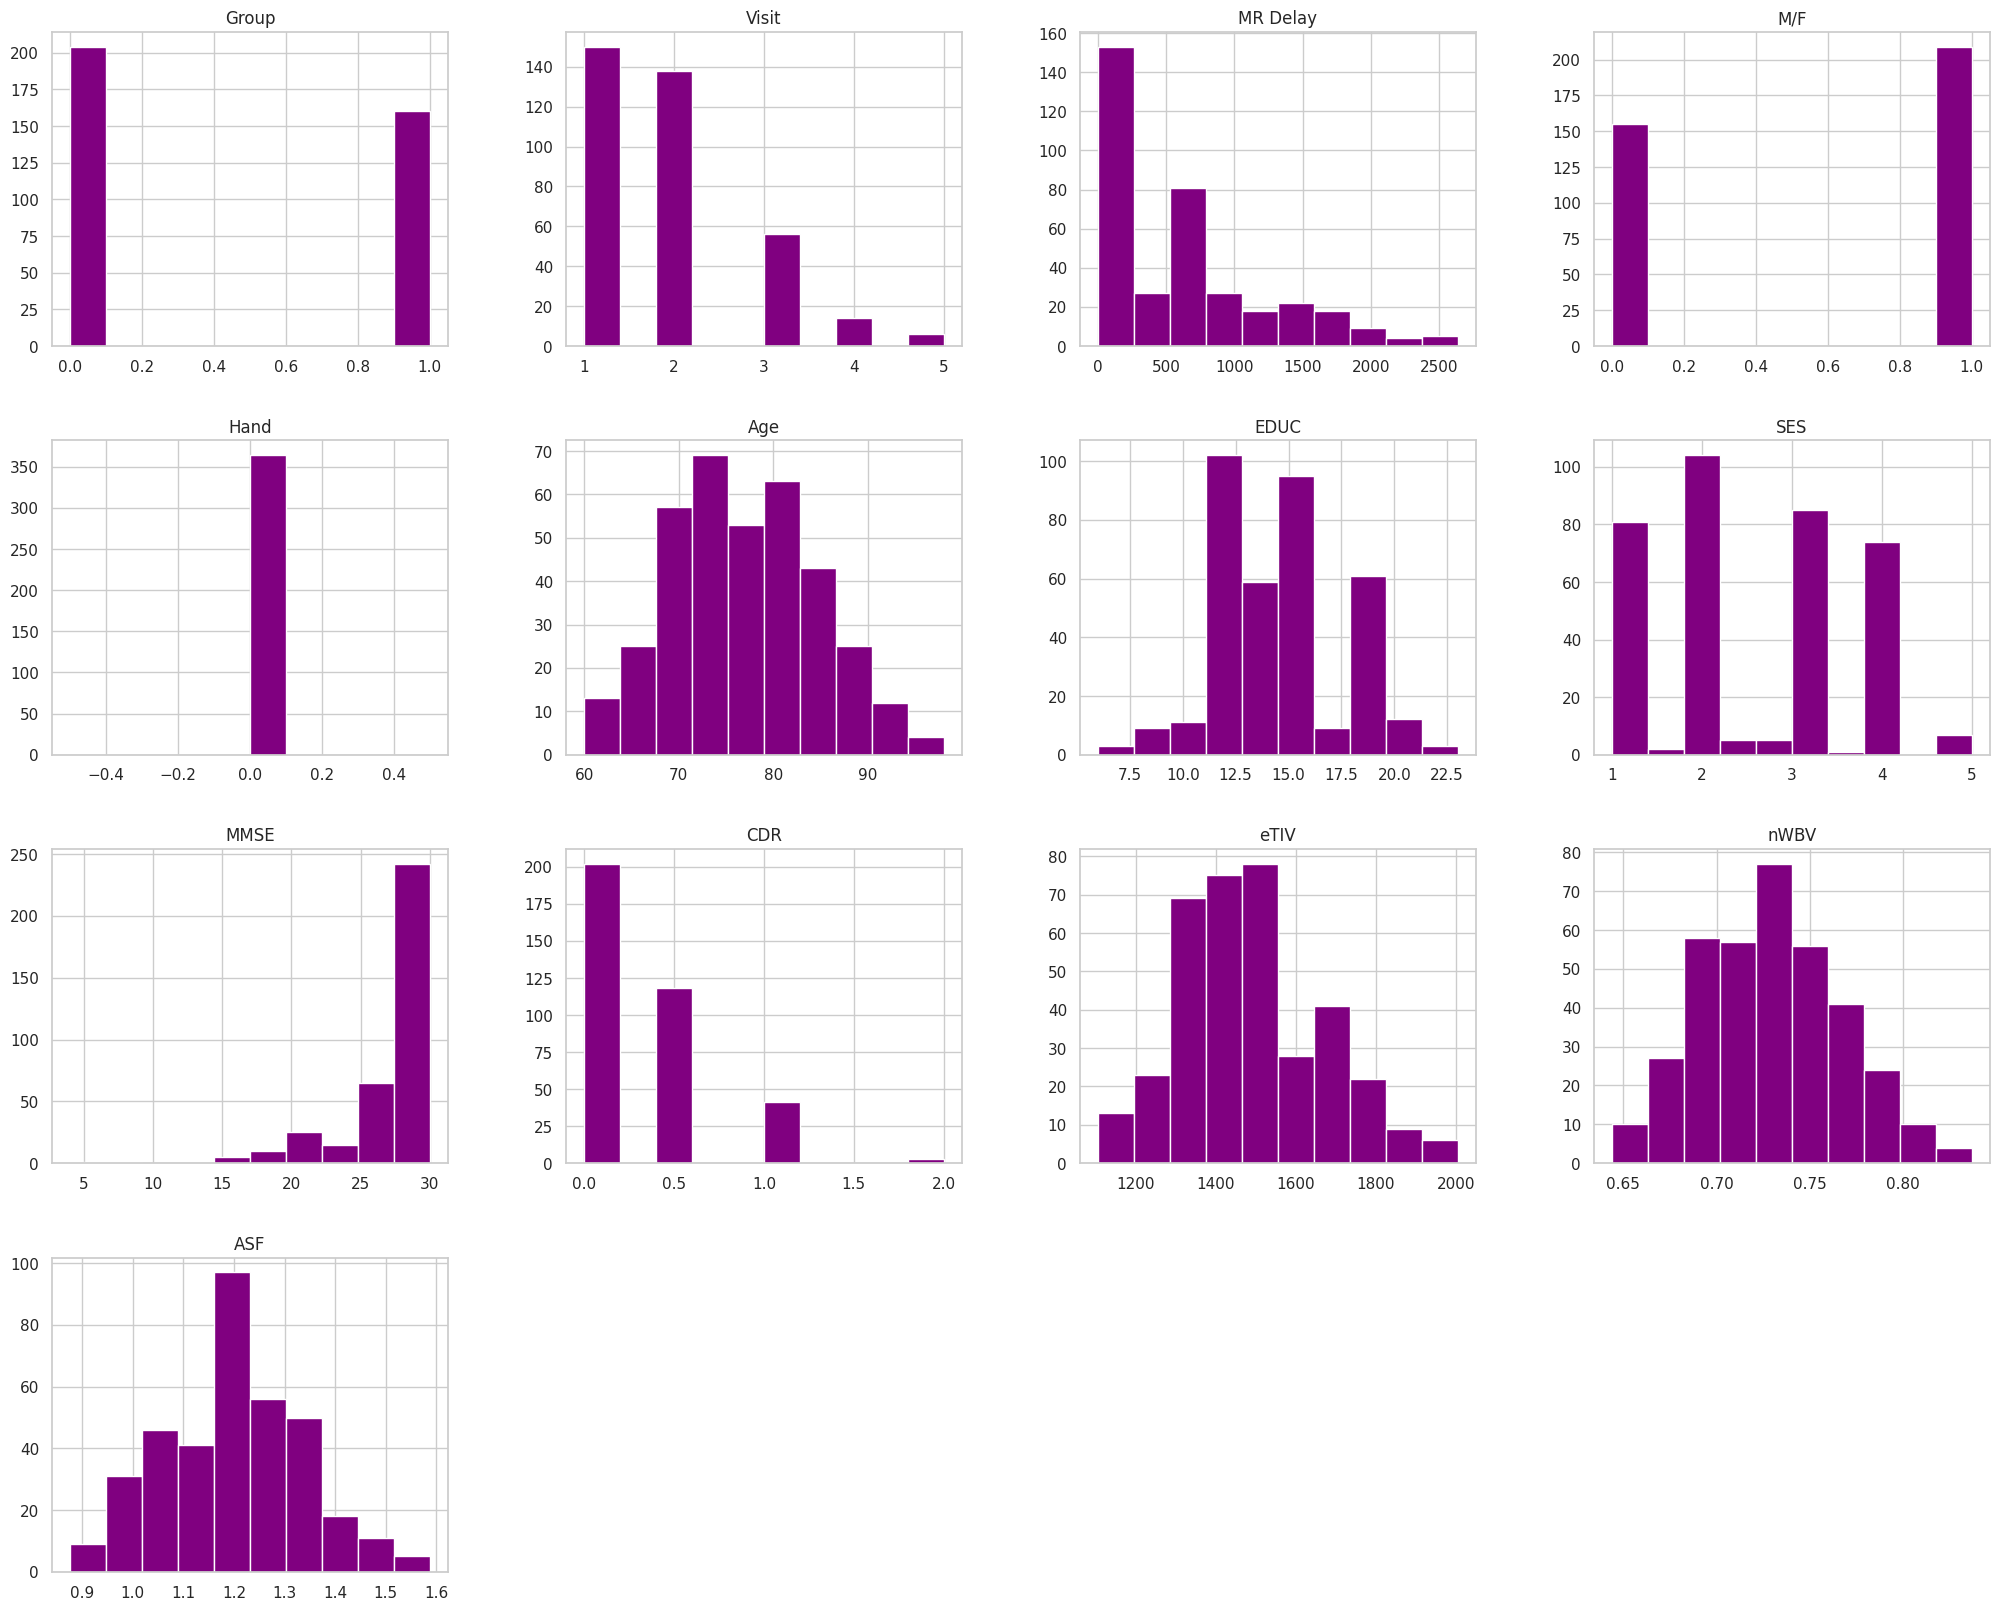

In [33]:
dementia_df.hist(figsize=(25,20))

As there is no variability in the 'Hand' feature, we will drop this too.

In [34]:
dementia_df = dementia_df.drop(columns='Hand')

### Correlations
---

We can now check the correlations between features in the dataset.

In [35]:
dementia_corr = dementia_df.copy().corr()
dementia_corr['Group'].sort_values(ascending = False)

Group       1.000000
CDR         0.851030
SES         0.138507
ASF         0.018254
eTIV       -0.024467
Age        -0.024938
Visit      -0.041414
MR Delay   -0.068817
EDUC       -0.232042
M/F        -0.244793
nWBV       -0.325175
MMSE       -0.592315
Name: Group, dtype: float64

We can plot this on a heatmap.

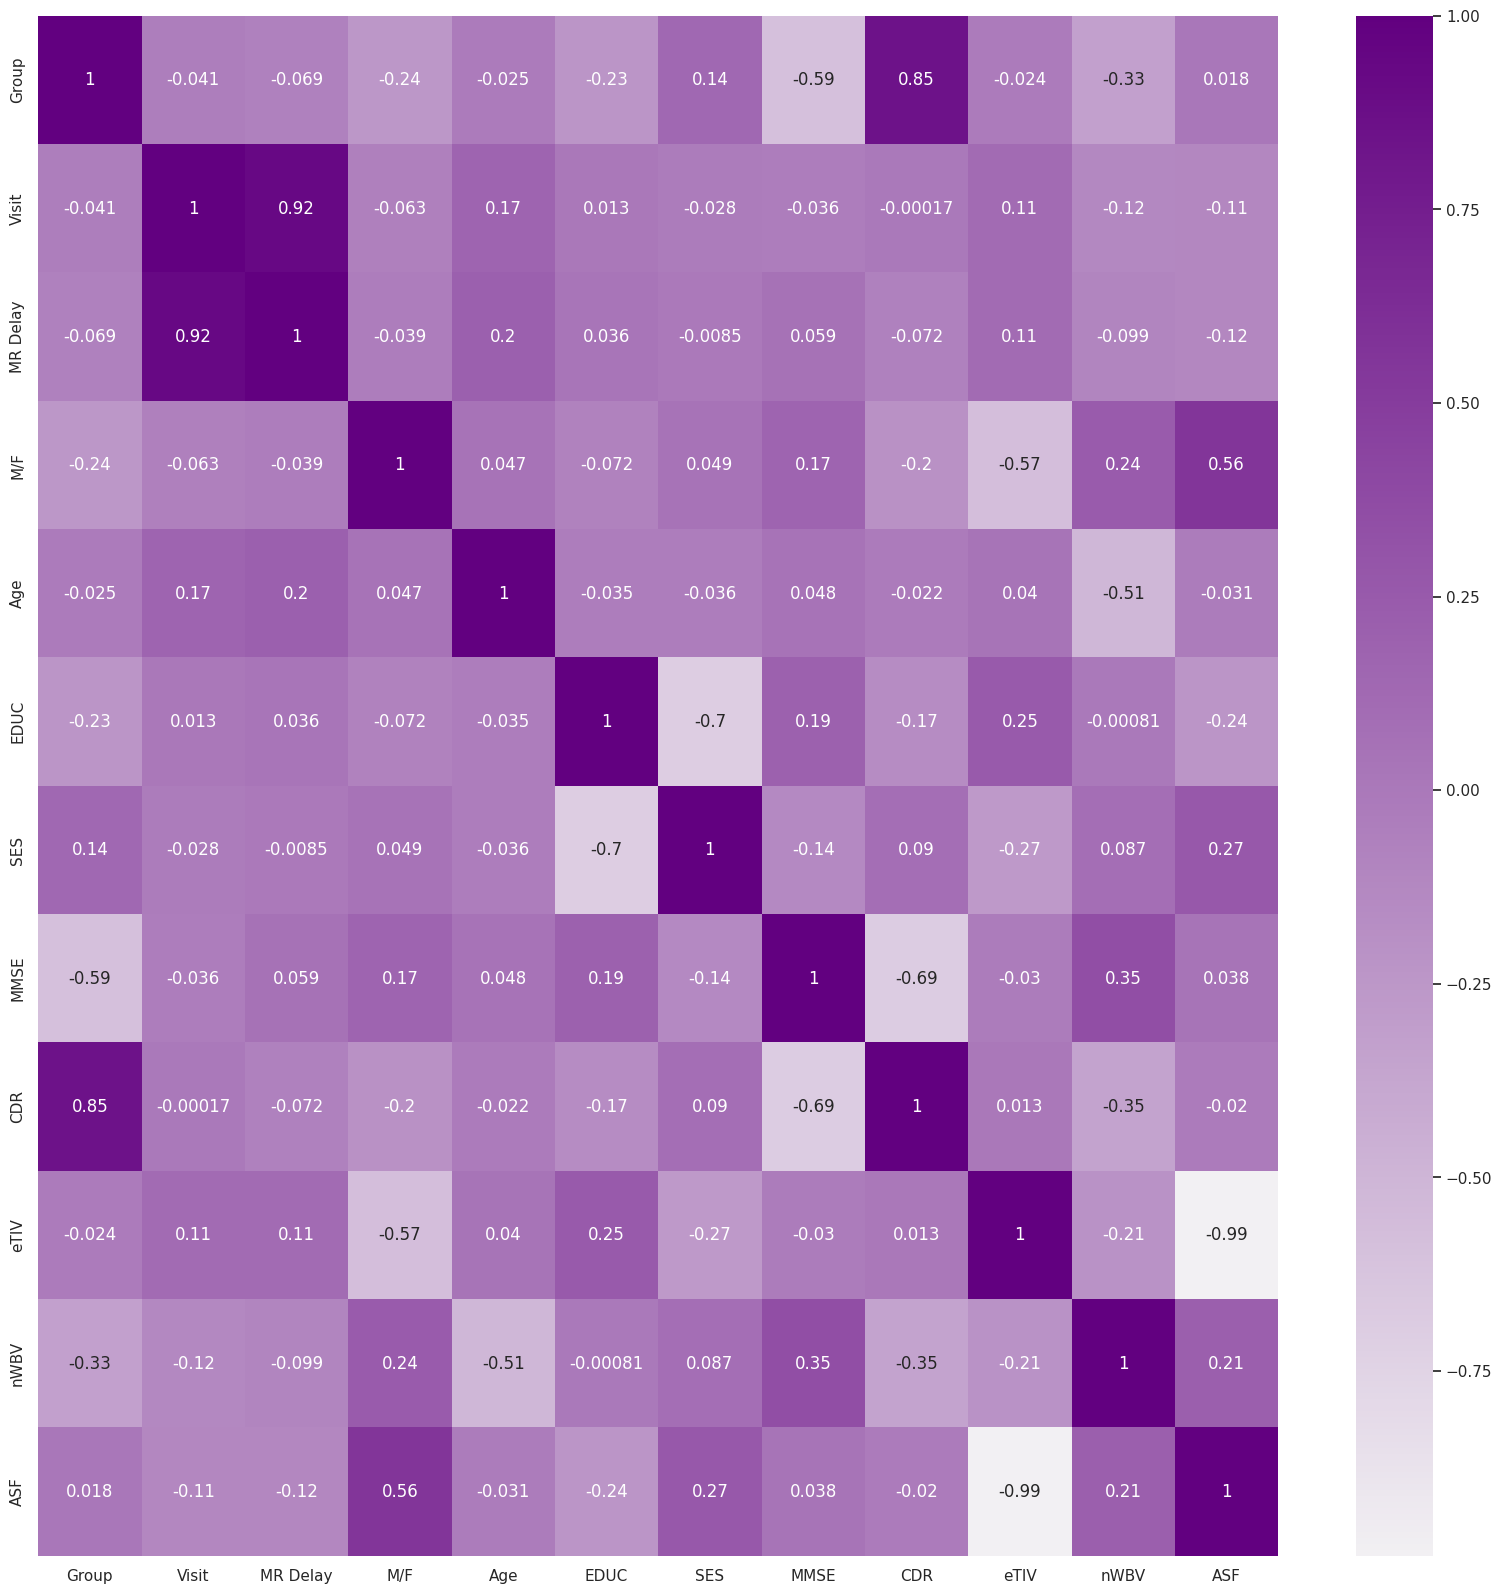

In [36]:
plt.figure(figsize=(20,20))
sns.heatmap(dementia_corr, annot=True, cmap=gradient_palette)
plt.show()

The correlation analysis reveals that CDR has the strongest positive correlation with the Group, indicating its significant role in predicting dementia severity. MMSE shows a strong negative correlation, with lower scores associated with dementia, making it another key predictor. nWBV also negatively correlates with the Group, suggesting that lower brain volume may be linked to dementia.

EDUC shows a moderate negative correlation, implying that lower education levels could be associated with a higher likelihood of dementia, though the effect is weaker. M/F indicates a slight male predominance in the demented group, but this is a minor factor. SES shows a weak positive correlation, suggesting higher socioeconomic status is slightly linked to the non-demented group, but this relationship is not strong. Other variables like Age, eTIV, Visit, MR Delay, and ASF have minimal correlations, suggesting they are less relevant for predicting dementia in this dataset.

In [37]:
important_features = ['Group', 'EDUC', 'MMSE', 'CDR', 'nWBV']

We can also visualise the important features in a pairplot.

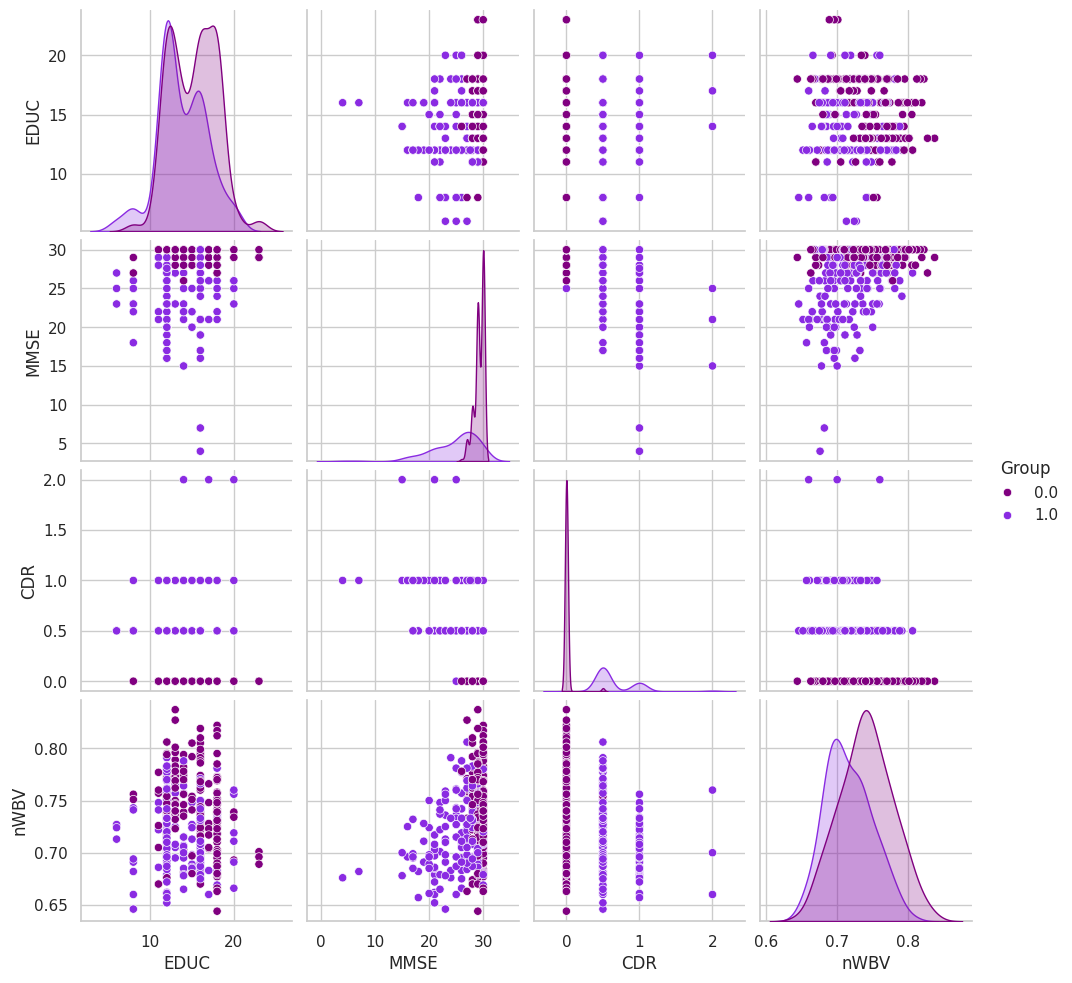

In [38]:
sns.pairplot(dementia_df[important_features], hue='Group', palette=palette)

And finally let's save the processed dataset.

In [39]:
dementia_df.head()

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0.0,1.0,0.0,0.0,87.0,14.0,2.0,27.0,0.0,1987.0,0.696,0.883
1,0.0,2.0,457.0,0.0,88.0,14.0,2.0,30.0,0.0,2004.0,0.681,0.876
2,1.0,1.0,0.0,0.0,75.0,12.0,1.8,23.0,0.5,1678.0,0.736,1.046
3,1.0,2.0,560.0,0.0,76.0,12.0,1.6,28.0,0.5,1738.0,0.713,1.010
4,1.0,3.0,1895.0,0.0,80.0,12.0,2.6,22.0,0.5,1698.0,0.701,1.034


In [40]:
dementia_df.to_csv('data/dementia_data_processed.csv', index=False)

# Parkinson's Disease Dataset
---

## Import Dataset & Examine
---

### Import Dataset
---

In [41]:
parkinsons_df = pd.read_csv('data/parkinsons_data-VOICE-features.csv')

In [42]:
parkinsons_df.rename(columns={'name': 'Name', 'status': 'Status'}, inplace=True)

### Dataset Info & Structure
---

In [43]:
print(parkinsons_df.shape)

(195, 24)


In [44]:
print(parkinsons_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [45]:
parkinsons_df.head()

,Name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,Status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


### Statistical Summary
---

In [46]:
parkinsons_df.describe().T

,count,mean,std,min,25%,50%,75%,max
MDVP:Fo(Hz),195.0,154.228641,41.390065,88.333000,117.572000,148.790000,182.769000,260.105000
MDVP:Fhi(Hz),195.0,197.104918,91.491548,102.145000,134.862500,175.829000,224.205500,592.030000
MDVP:Flo(Hz),195.0,116.324631,43.521413,65.476000,84.291000,104.315000,140.018500,239.170000
MDVP:Jitter(%),195.0,0.006220,0.004848,0.001680,0.003460,0.004940,0.007365,0.033160
MDVP:Jitter(Abs),195.0,0.000044,0.000035,0.000007,0.000020,0.000030,0.000060,0.000260
MDVP:RAP,195.0,0.003306,0.002968,0.000680,0.001660,0.002500,0.003835,0.021440
MDVP:PPQ,195.0,0.003446,0.002759,0.000920,0.001860,0.002690,0.003955,0.019580
Jitter:DDP,195.0,0.009920,0.008903,0.002040,0.004985,0.007490,0.011505,0.064330
MDVP:Shimmer,195.0,0.029709,0.018857,0.009540,0.016505,0.022970,0.037885,0.119080
MDVP:Shimmer(dB),195.0,0.282251,0.194877,0.085000,0.148500,0.221000,0.350000,1.302000


In [47]:
print(f"Number of unique subjects: {len(parkinsons_df['Name'].unique())}")

Number of unique subjects: 195


## Preparing the data
---

### Target Examination
---

<Axes: xlabel='Status', ylabel='count'>

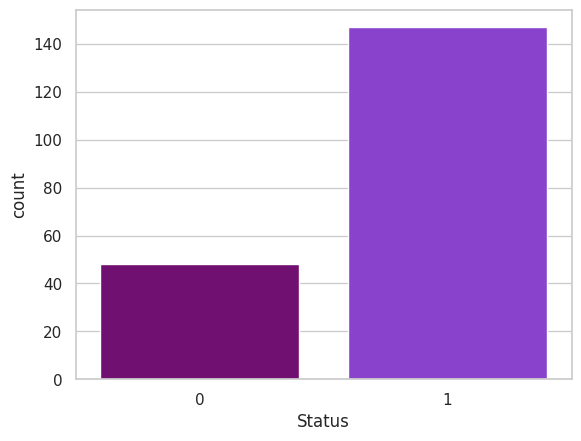

In [48]:
sns.countplot(x=parkinsons_df['Status'], palette=palette)

In [49]:
parkinsons_df.Status.value_counts()

Status
1    147
0     48
Name: count, dtype: int64

As there are no repeated patients in this dataset, we can remove the 'name' column.

In [50]:
parkinsons_df = parkinsons_df.drop(columns=['Name'])

### Data Types
---

As we saw from the dataset info, the only non-numerical column has been dropped, so we do not need to change any datatypes for this dataset.

### Missing values
---

In [51]:
parkinsons_df.isnull().sum()

MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
Status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

As we can see, there are no missing values in this dataset, so we do not need to do anything here.

## Data Distribution & Correlation
---

### Skewness Analysis
---

In [52]:
parkinsons_df.skew()

MDVP:Fo(Hz)         0.591737
MDVP:Fhi(Hz)        2.542146
MDVP:Flo(Hz)        1.217350
MDVP:Jitter(%)      3.084946
MDVP:Jitter(Abs)    2.649071
MDVP:RAP            3.360708
MDVP:PPQ            3.073892
Jitter:DDP          3.362058
MDVP:Shimmer        1.666480
MDVP:Shimmer(dB)    1.999389
Shimmer:APQ3        1.580576
Shimmer:APQ5        1.798697
MDVP:APQ            2.618047
Shimmer:DDA         1.580618
NHR                 4.220709
HNR                -0.514317
Status             -1.187727
RPDE               -0.143402
DFA                -0.033214
spread1             0.432139
spread2             0.144430
D2                  0.430384
PPE                 0.797491
dtype: float64

The MDVP-related features, such as MDVP: Fhi(Hz), MDVP: Jitter(%), and MDVP: RAP, exhibit strong positive skew, indicating that most values are clustered at the lower end with some extreme higher values. These features are likely important for prediction, as the spread of values can help distinguish between different conditions.

NHR also shows significant positive skew, while HNR and status have negative skew, with values concentrated towards the higher end.

Other features like RPDE, DFA, spread1, and spread2 have near-zero skew, implying more symmetric distributions.

We can compare this to the skewness of features for healthy and diseased patients specifically.

In [53]:
healthy = parkinsons_df[parkinsons_df['Status'] == 1]
diseased = parkinsons_df[parkinsons_df['Status'] == 0]

In [54]:
skew_comparison = pd.DataFrame({
    'Overall': parkinsons_df.skew(),
    'Healthy': healthy.skew(),
    'Diseased': diseased.skew()
})

In [55]:
print(skew_comparison)

                   Overall   Healthy  Diseased
MDVP:Fo(Hz)       0.591737  0.366850 -0.206080
MDVP:Fhi(Hz)      2.542146  2.803273  2.191357
MDVP:Flo(Hz)      1.217350  0.893664  0.454401
MDVP:Jitter(%)    3.084946  2.857486  2.595196
MDVP:Jitter(Abs)  2.649071  2.554055  1.203508
MDVP:RAP          3.360708  3.059989  2.227438
MDVP:PPQ          3.073892  2.791292  1.898408
Jitter:DDP        3.362058  3.061427  2.227230
MDVP:Shimmer      1.666480  1.370146  1.632775
MDVP:Shimmer(dB)  1.999389  1.716727  1.744643
Shimmer:APQ3      1.580576  1.282823  1.495943
Shimmer:APQ5      1.798697  1.477983  2.005412
MDVP:APQ          2.618047  2.376708  1.043889
Shimmer:DDA       1.580618  1.282875  1.495657
NHR               4.220709  3.903748  3.702145
HNR              -0.514317 -0.619045  0.363758
Status           -1.187727  0.000000  0.000000
RPDE             -0.143402 -0.330289  0.311439
DFA              -0.033214 -0.151460  0.278665
spread1           0.432139  0.558212  0.414532
spread2      

We can plot this data to more easily visualise it.

To do this we need to ensure the skew_comparison DataFrame has a column for variable names.

In [56]:
skew_comparison = skew_comparison.reset_index().rename(columns={'index': 'Variable'})

And then reshape the DataFrame.

In [57]:
skew_comparison = pd.melt(skew_comparison, id_vars='Variable', var_name='Status', value_name='Skewness')

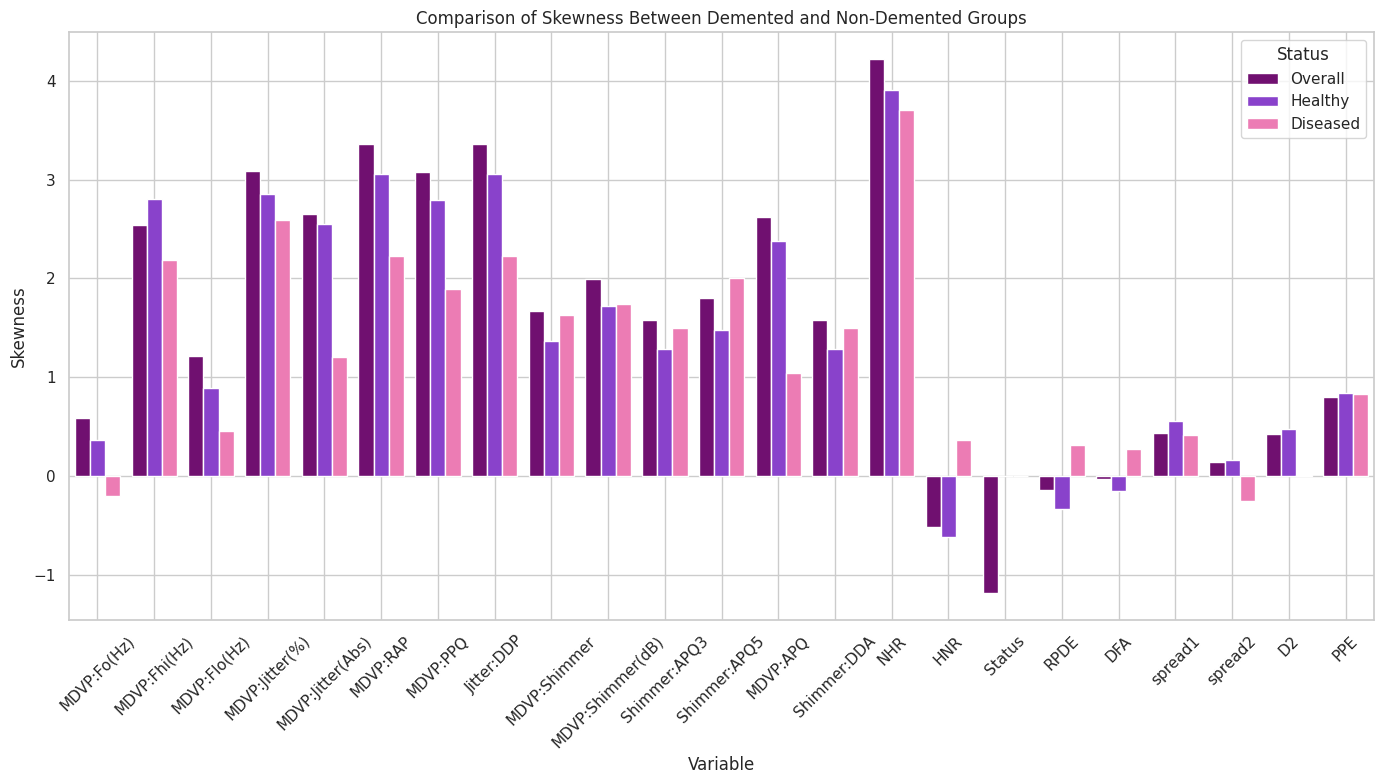

In [58]:
plt.figure(figsize=(14, 8))
sns.barplot(x='Variable', y='Skewness', hue='Status', data=skew_comparison)
plt.title('Comparison of Skewness Between Demented and Non-Demented Groups')
plt.xlabel('Variable')
plt.ylabel('Skewness')
plt.xticks(rotation=45)
plt.legend(title='Status')
plt.grid(True)
plt.tight_layout()
plt.show()

The skewness analysis of the Parkinson's dataset reveals several notable patterns between the Healthy and Diseased groups. MDVP: Fo(Hz) and MDVP: Fhi(Hz) exhibit high skewness in both groups, with the Healthy group showing a more pronounced positive skew, indicating that these features are more variable in the healthy population. MDVP Flo(Hz), MDVP: Jitter(%), and MDVP: Jitter(Abs) also show moderate skewness in both groups, with the Diseased group tending towards less positive skew, which could point to lower variability in these features for individuals with Parkinson's.

Shimmer-related features like MDVP: Shimmer and Shimmer: APQ5 are more skewed in the Healthy group, suggesting more variability in this measure for healthy individuals. On the other hand, MDVP: APQ has higher skewness in the Healthy group, possibly indicating a different vocal pattern or greater variance in healthy individuals compared to the diseased ones.

NHR shows significant positive skew in both groups, but the Healthy group has a higher skew, possibly reflecting more pronounced differences in speech-related features for healthy individuals.

HNR, Status, RPDE, DFA, and spread2 all exhibit negative skew, with HNR showing a more pronounced negative skew in the Diseased group. The negative skew of Status could reflect the distribution of disease severity, with most diseased individuals falling into lower severity levels.

### Histogram
---

array([[<Axes: title={'center': 'MDVP:Fo(Hz)'}>,
        <Axes: title={'center': 'MDVP:Fhi(Hz)'}>,
        <Axes: title={'center': 'MDVP:Flo(Hz)'}>,
        <Axes: title={'center': 'MDVP:Jitter(%)'}>,
        <Axes: title={'center': 'MDVP:Jitter(Abs)'}>],
       [<Axes: title={'center': 'MDVP:RAP'}>,
        <Axes: title={'center': 'MDVP:PPQ'}>,
        <Axes: title={'center': 'Jitter:DDP'}>,
        <Axes: title={'center': 'MDVP:Shimmer'}>,
        <Axes: title={'center': 'MDVP:Shimmer(dB)'}>],
       [<Axes: title={'center': 'Shimmer:APQ3'}>,
        <Axes: title={'center': 'Shimmer:APQ5'}>,
        <Axes: title={'center': 'MDVP:APQ'}>,
        <Axes: title={'center': 'Shimmer:DDA'}>,
        <Axes: title={'center': 'NHR'}>],
       [<Axes: title={'center': 'HNR'}>,
        <Axes: title={'center': 'Status'}>,
        <Axes: title={'center': 'RPDE'}>,
        <Axes: title={'center': 'DFA'}>,
        <Axes: title={'center': 'spread1'}>],
       [<Axes: title={'center': 'spread2'}>,
   

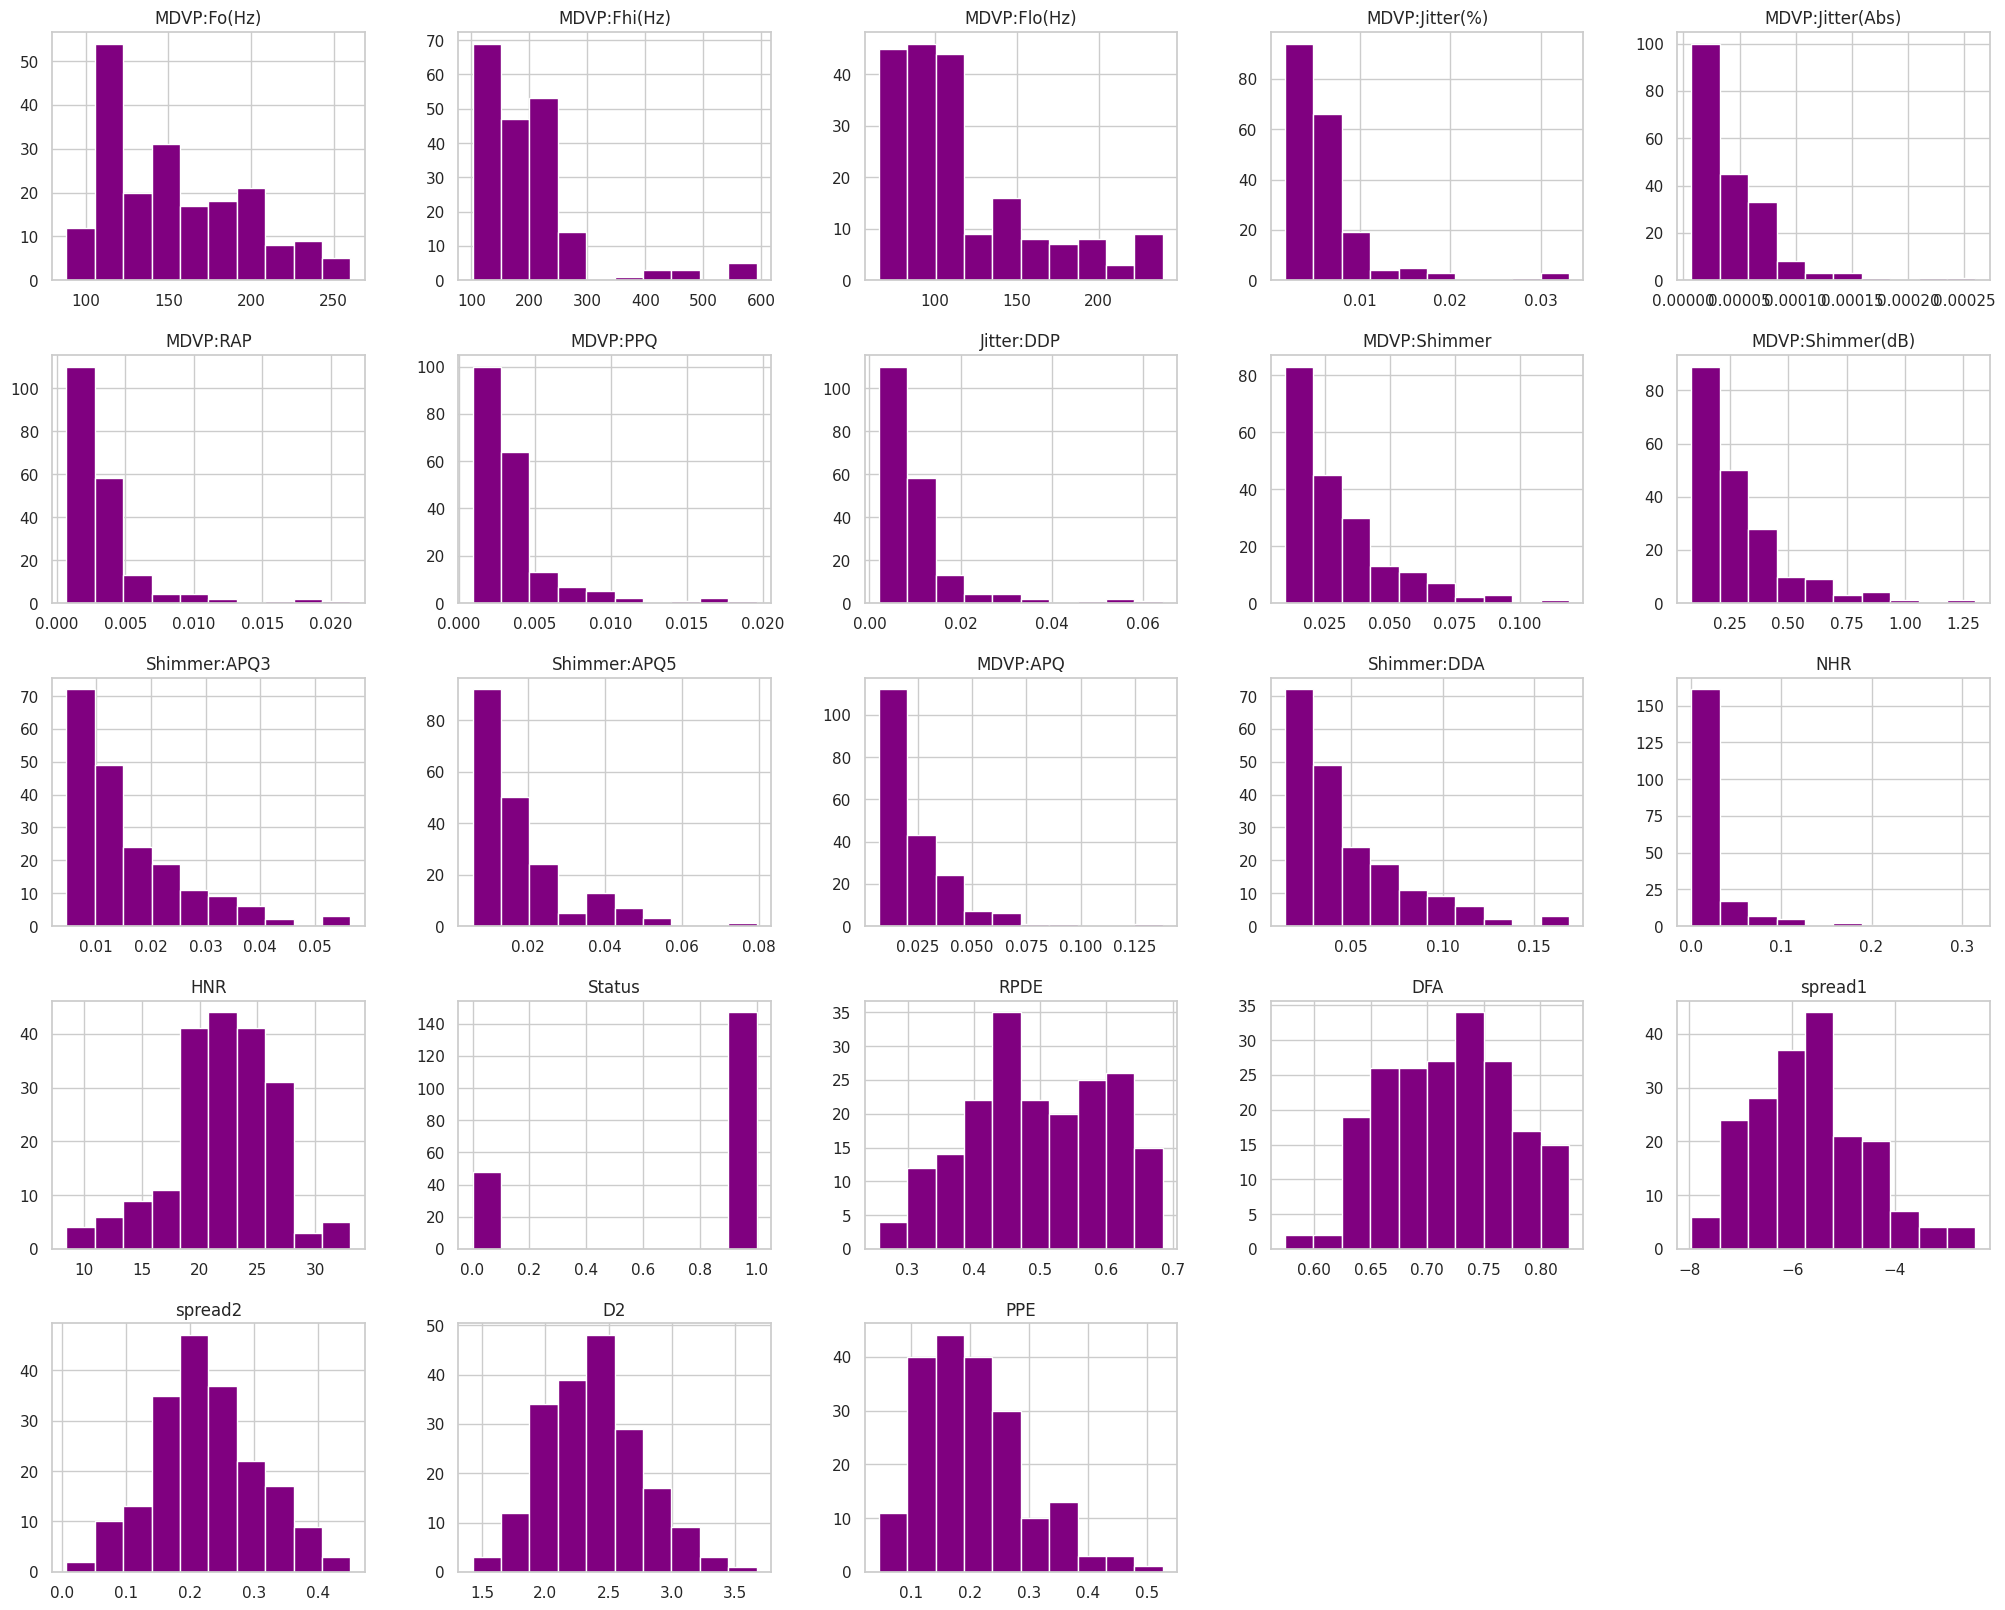

In [59]:
parkinsons_df.hist(figsize=(25,20))

### Correlations
---

We can now check the correlations between features in the dataset.

In [60]:
parkinsons_corr = parkinsons_df.copy().corr()
parkinsons_corr['Status'].sort_values(ascending=False)

Status              1.000000
spread1             0.564838
PPE                 0.531039
spread2             0.454842
MDVP:Shimmer        0.367430
MDVP:APQ            0.364316
Shimmer:APQ5        0.351148
MDVP:Shimmer(dB)    0.350697
Shimmer:APQ3        0.347617
Shimmer:DDA         0.347608
D2                  0.340232
MDVP:Jitter(Abs)    0.338653
RPDE                0.308567
MDVP:PPQ            0.288698
MDVP:Jitter(%)      0.278220
MDVP:RAP            0.266668
Jitter:DDP          0.266646
DFA                 0.231739
NHR                 0.189429
MDVP:Fhi(Hz)       -0.166136
HNR                -0.361515
MDVP:Flo(Hz)       -0.380200
MDVP:Fo(Hz)        -0.383535
Name: Status, dtype: float64

We can plot this on a heatmap.

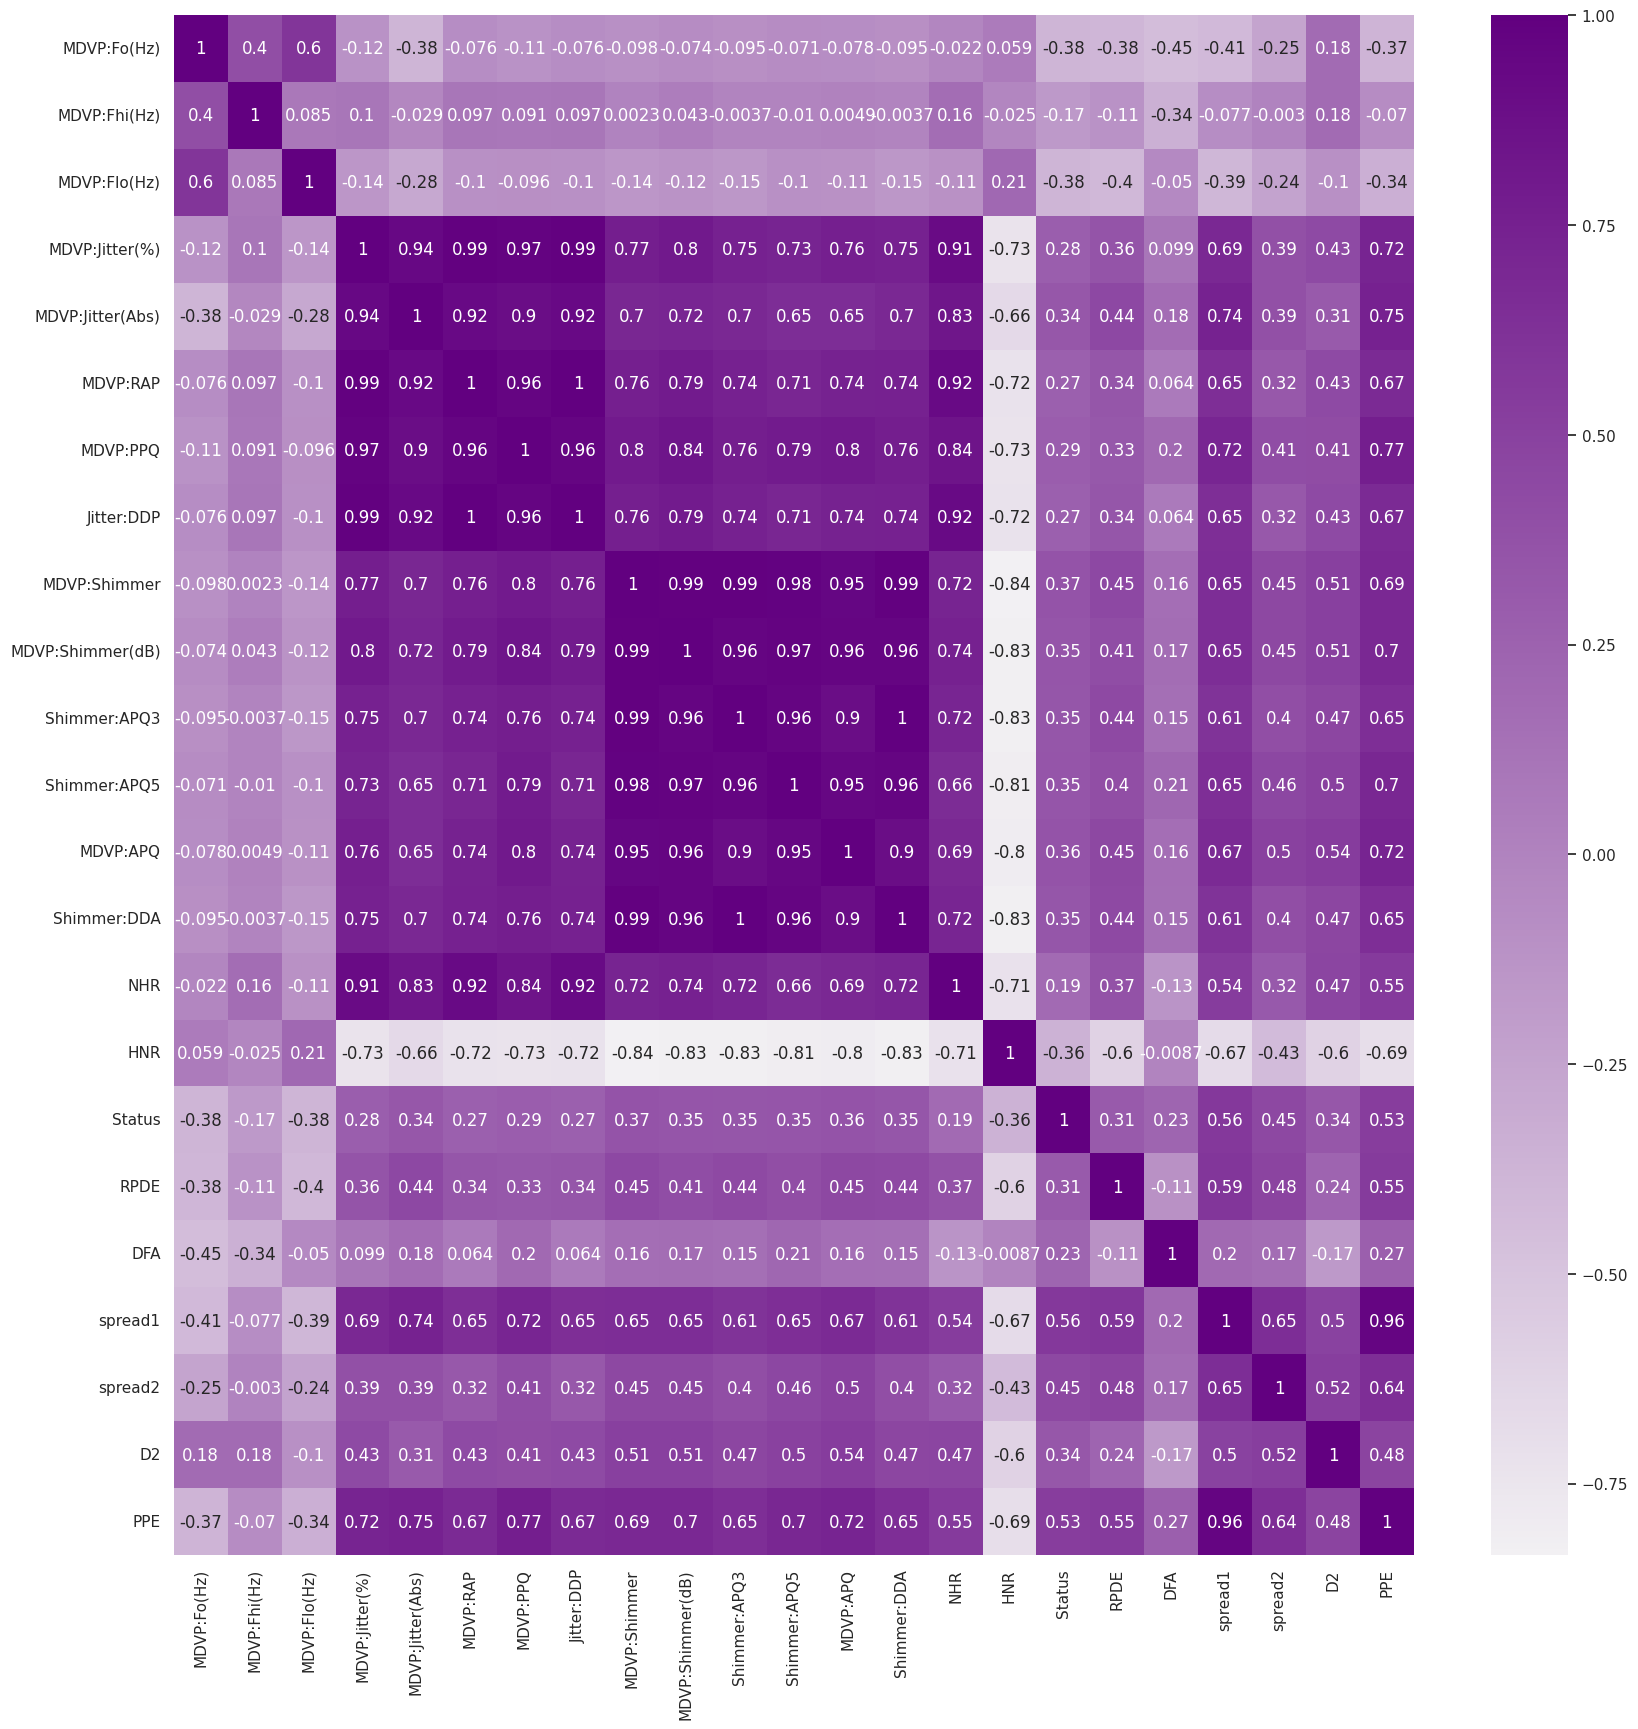

In [61]:
plt.figure(figsize=(20,20))
sns.heatmap(parkinsons_corr, annot=True, cmap=gradient_palette)
plt.show()

The correlation analysis of the Parkinson's dataset reveals several important patterns related to the Status of the individuals. Spread1 and PPE show the strongest positive correlations with Status, indicating that greater variability in speech features and potentially higher vocal effort are associated with more severe Parkinson's symptoms. Spread2 also shows a moderate positive correlation, suggesting a similar relationship, though slightly weaker.

Speech-related features like MDVP: Shimmer, MDVP: APQ, and Shimmer: APQ5 have moderate positive correlations with Status, implying that these features are linked to disease severity in Parkinson's patients. Notably, MDVP: Shimmer(dB) and Shimmer: APQ3 also correlate moderately with Status, pointing to their potential role in distinguishing between stages of Parkinson's.

D2 and MDVP: Jitter(Abs) show weaker positive correlations, highlighting that vocal features associated with irregularities and pitch variation may also be relevant for assessing the severity of Parkinson's, though their impact is less pronounced than the other speech features.

On the other hand, HNR, MDVP: Fo(Hz), and MDVP: Flo(Hz) show negative correlations with Status, suggesting that lower values of these features may be associated with more severe Parkinson's symptoms. The stronger negative correlation between HNR and Status indicates that speech harmonics, which are influenced by vocal quality, could serve as a significant indicator of disease progression.

In summary, speech features such as Spread1, PPE, and MDVP: Shimmer have the strongest correlations with disease severity in Parkinson's patients, while features like HNR and MDVP: Fo(Hz) show significant negative correlations. This suggests that both the variability and quality of speech may be key indicators for predicting the severity of Parkinson's disease.

In [62]:
important_features = ['Status', 'spread1', 'PPE', 'MDVP:Shimmer', 'MDVP:APQ', 'Shimmer:APQ5', 'Shimmer:DDA', 'MDVP:Shimmer(dB)', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:Flo(Hz)']

We can also visualise the important features in a pairplot.

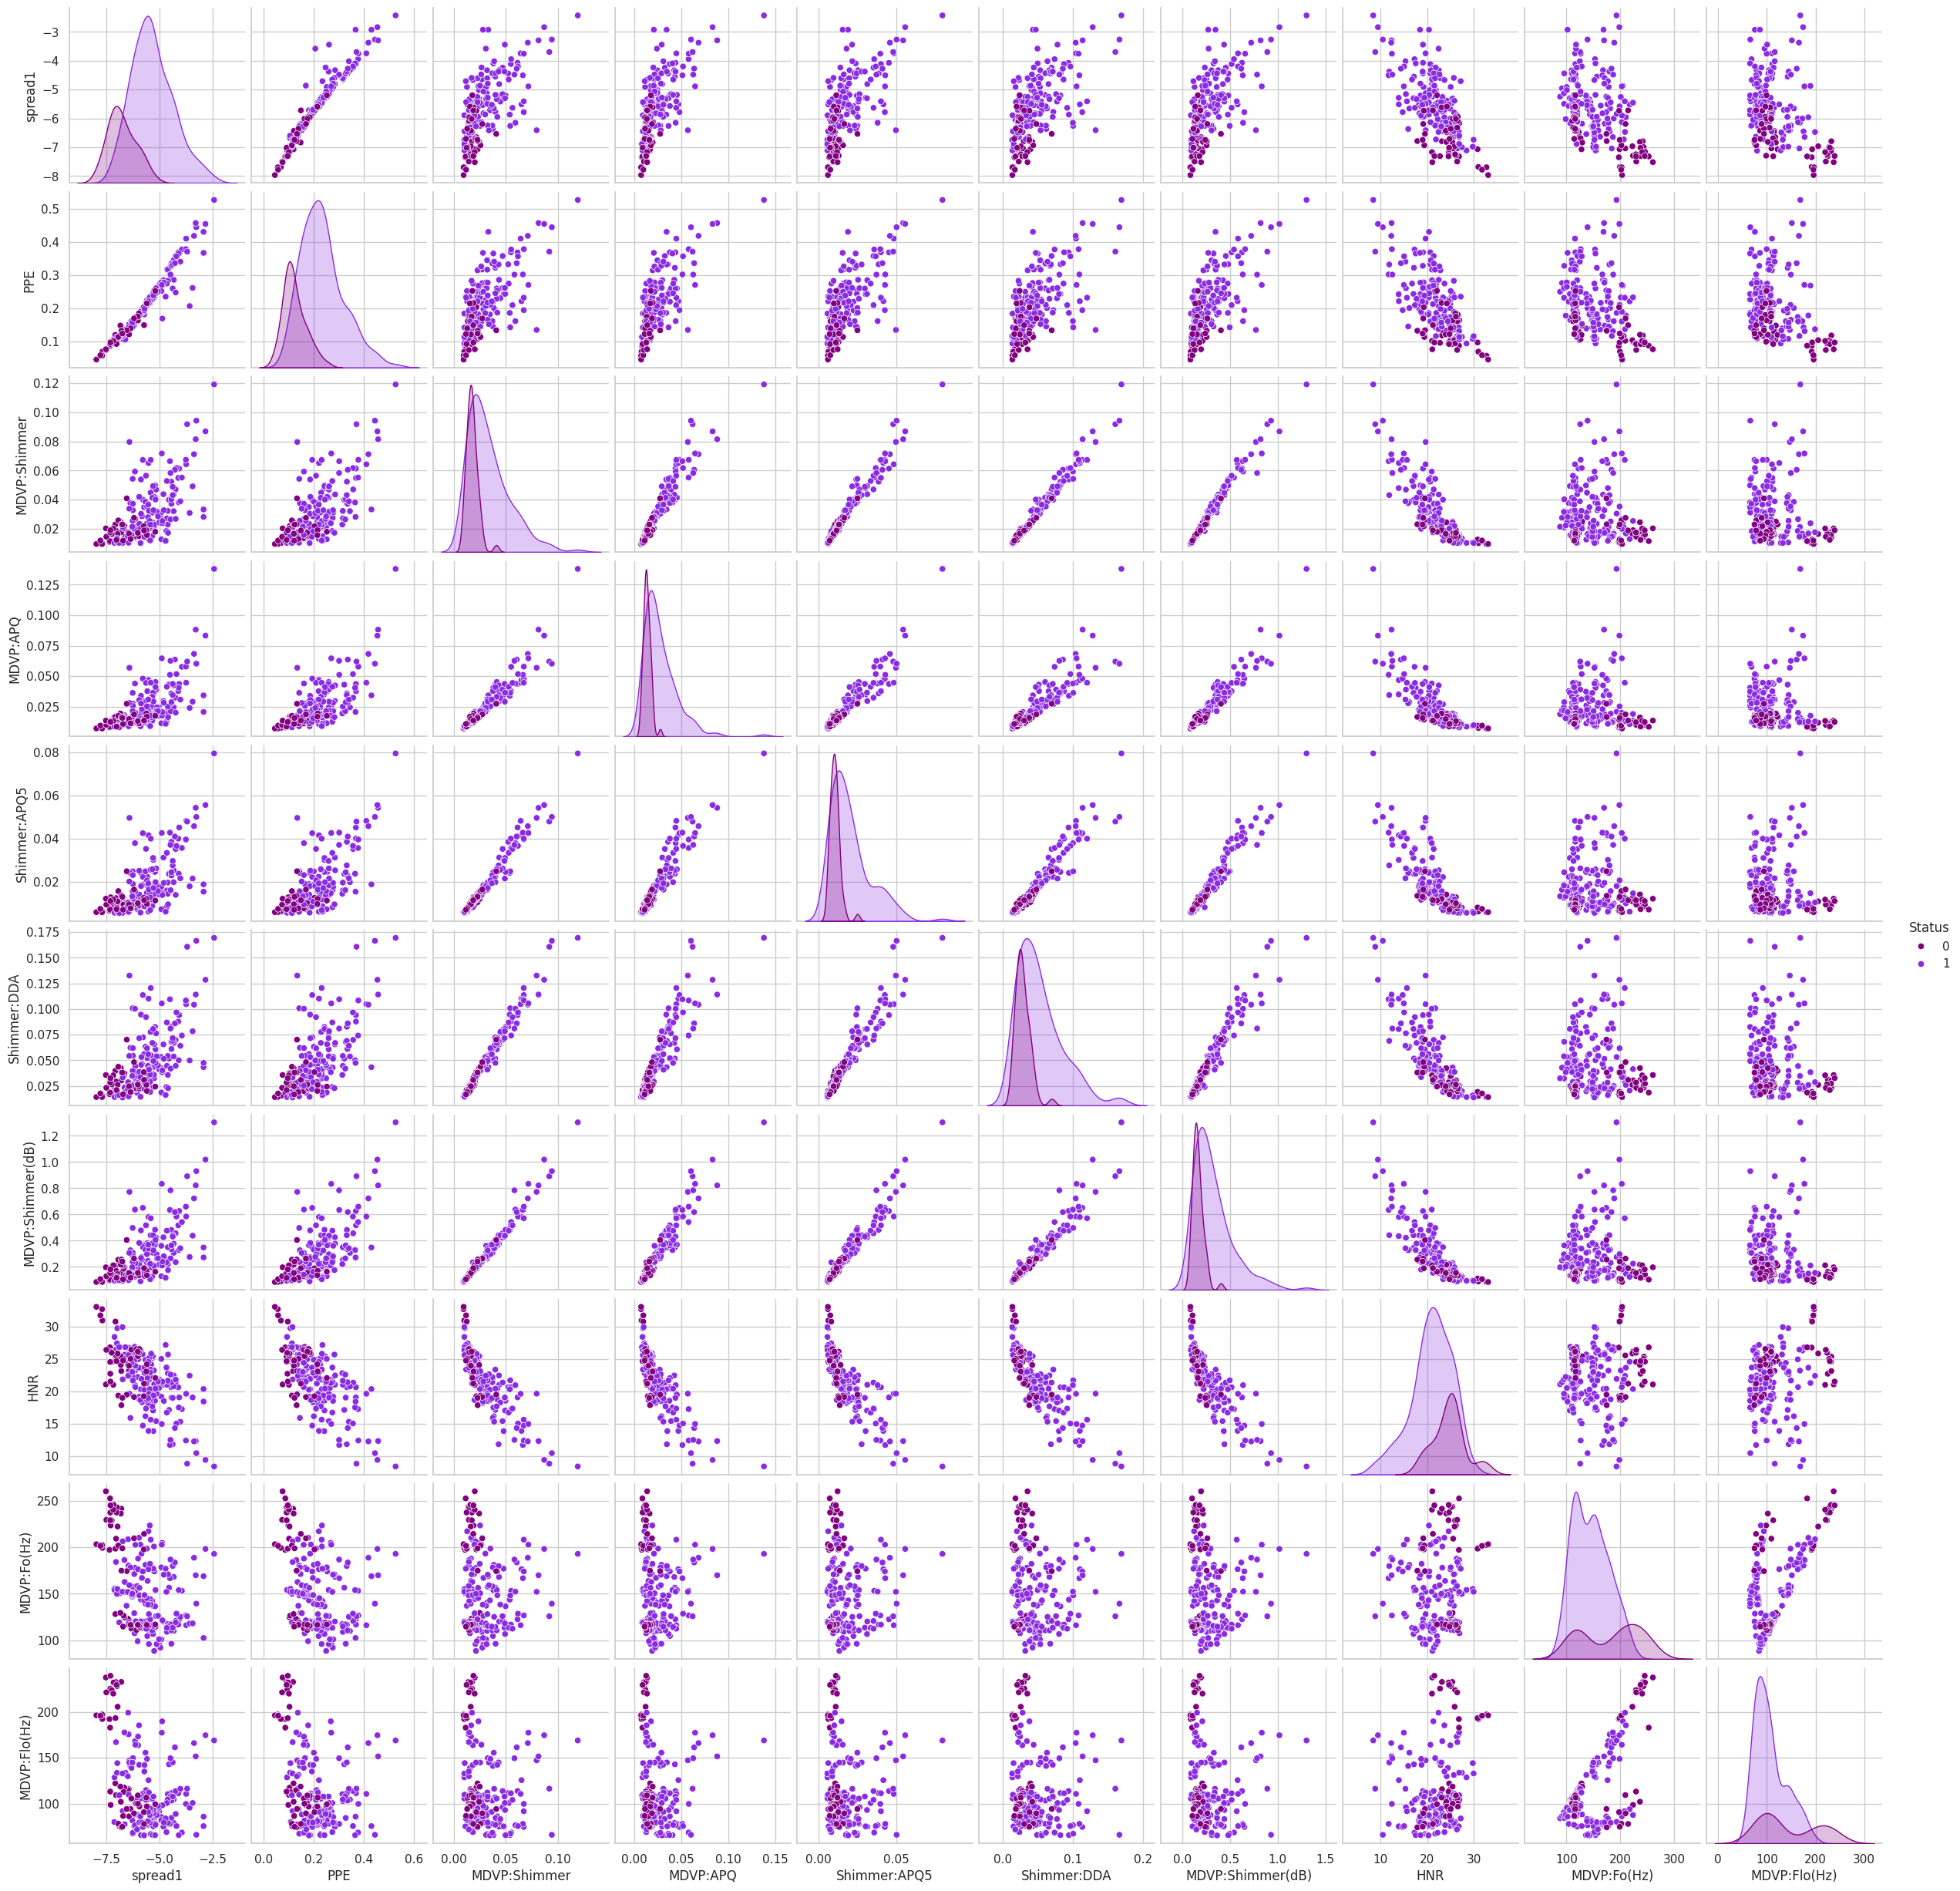

In [63]:
sns.pairplot(parkinsons_df[important_features], hue='Status', palette=palette)

And finally let's save the processed dataset.

In [64]:
parkinsons_df.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,Status,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [65]:
dementia_df.to_csv('data/parkinsons_data_processed.csv', index=False)